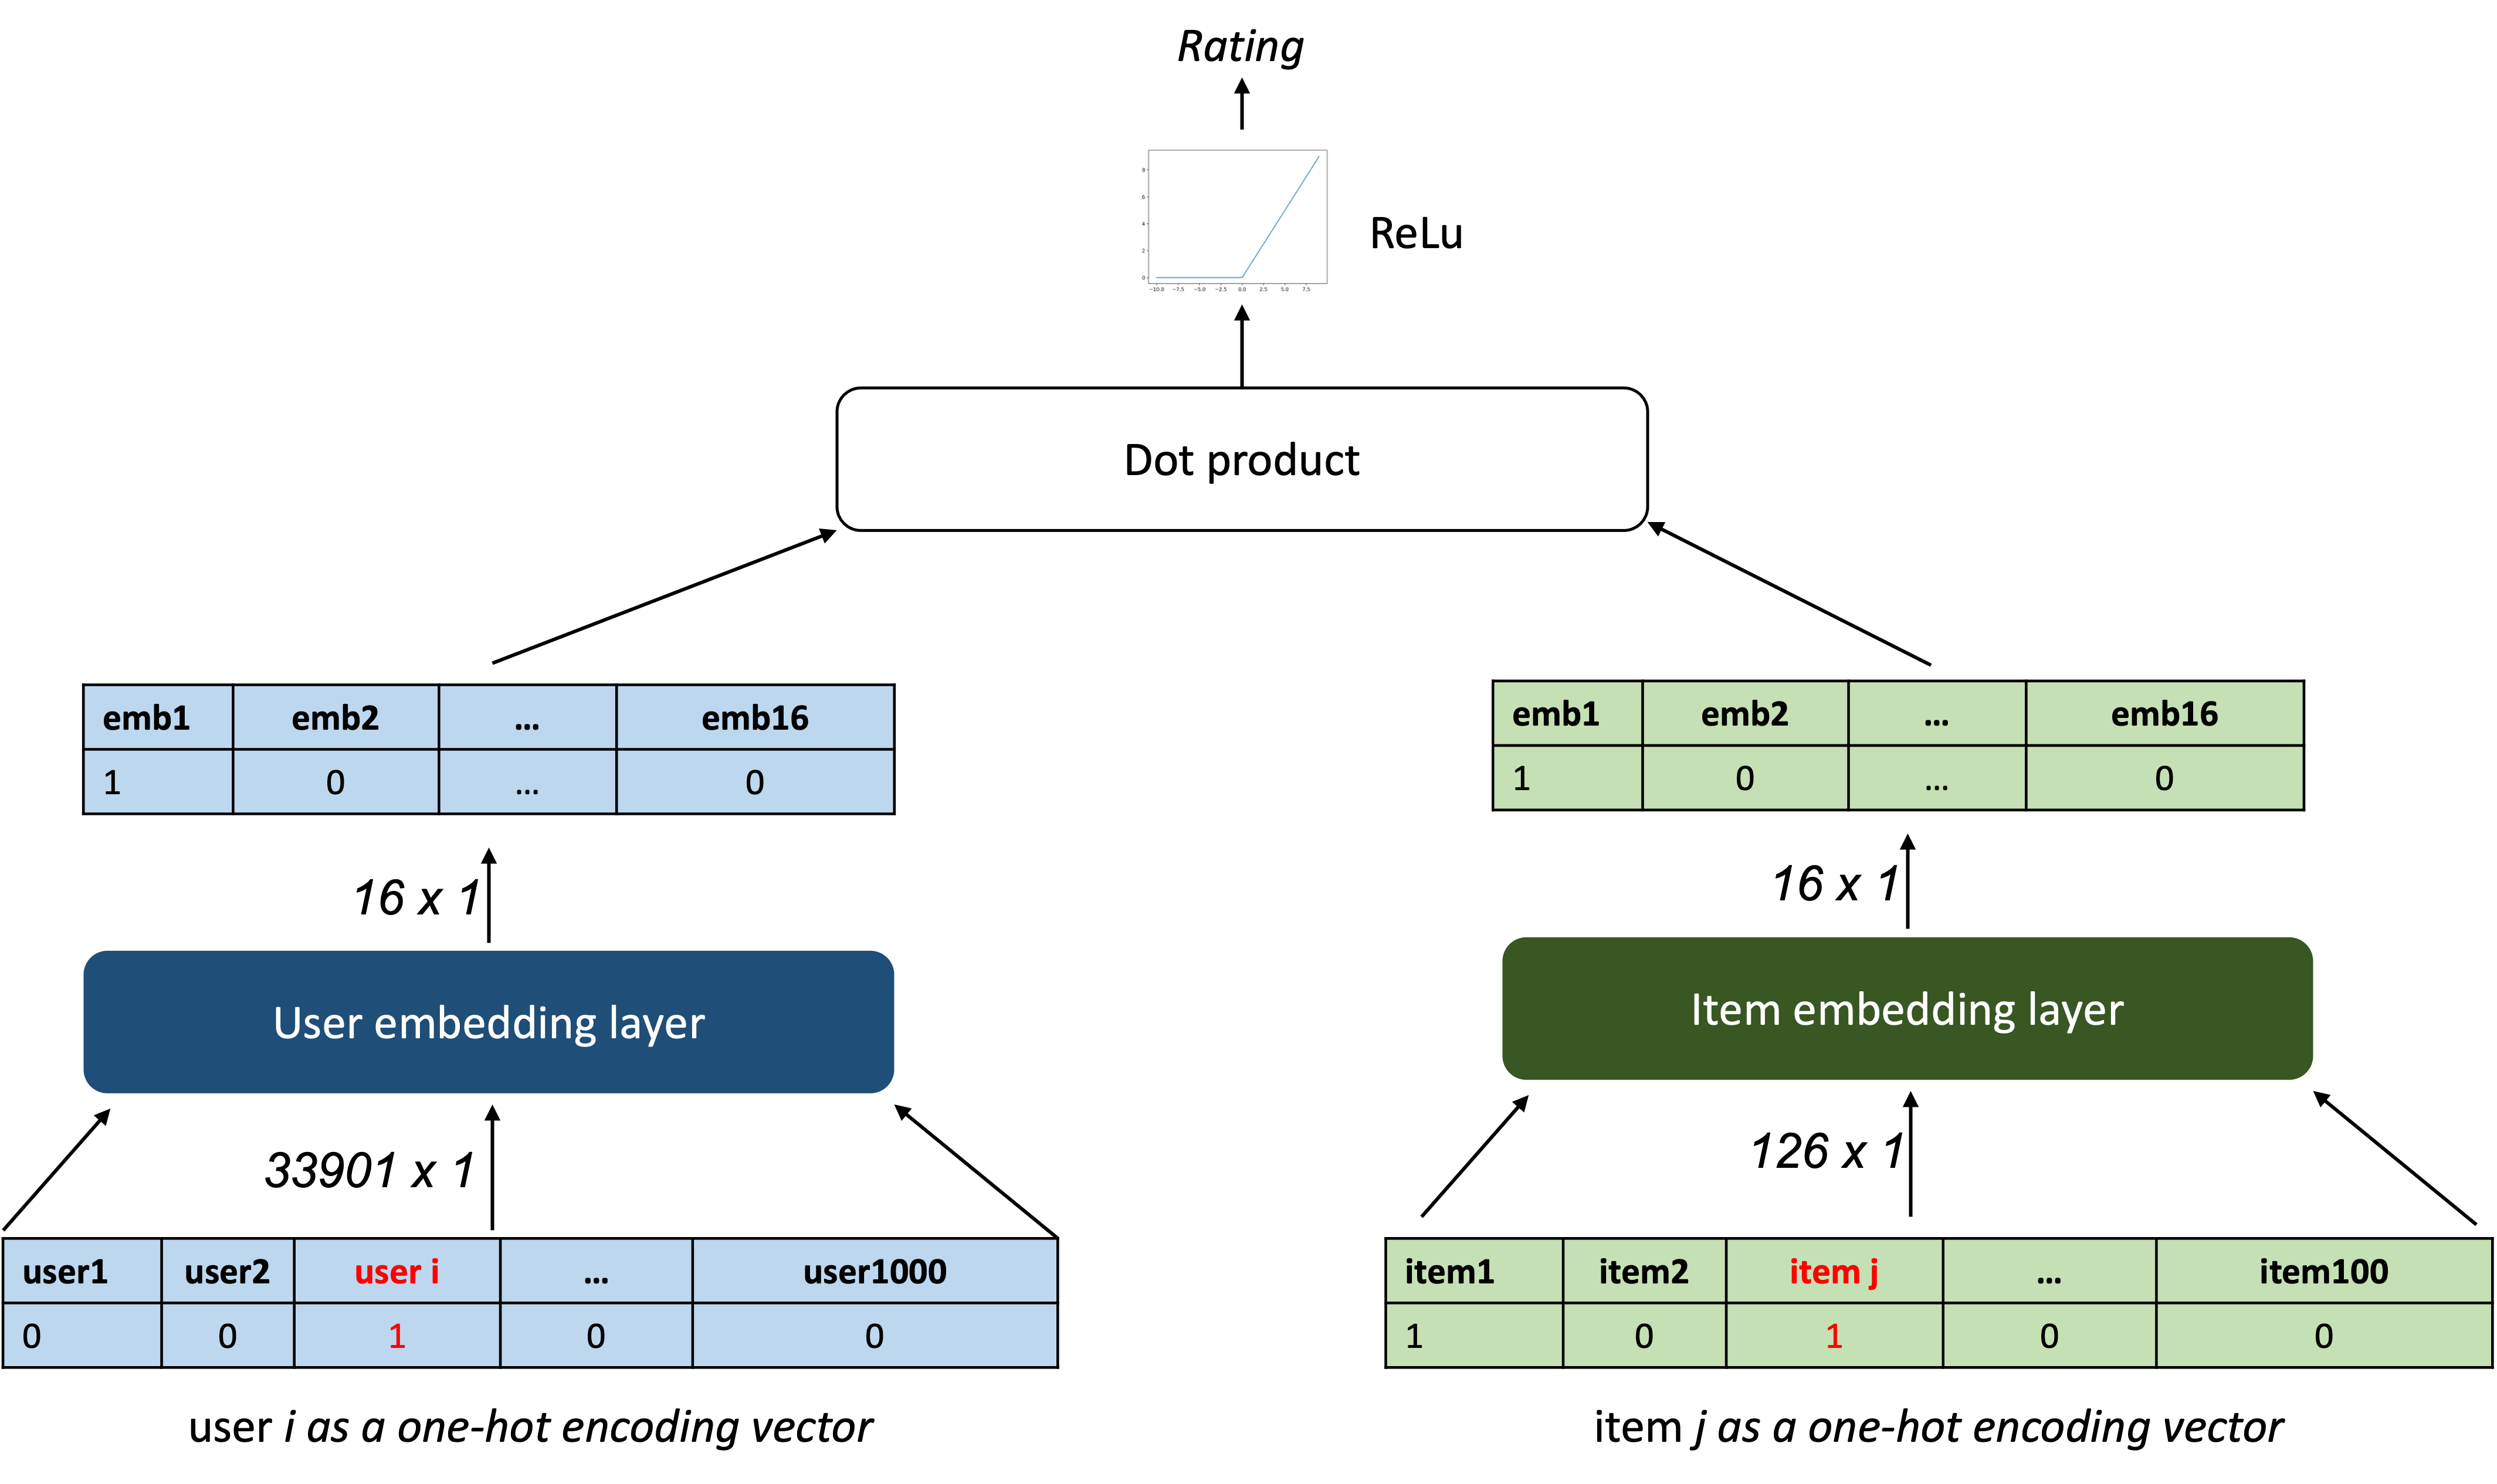

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("arashnic/book-recommendation-dataset")

print("Path to dataset files:", path)

100%|██████████| 24.3M/24.3M [00:00<00:00, 169MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/arashnic/book-recommendation-dataset/versions/3


In [ ]:
import os
ratings = os.path.join(path, "Ratings.csv")
data = pd.read_csv(ratings)
data.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [ ]:
data['Book-Rating'].value_counts()

,count
Book-Rating,
0,716109
8,103736
10,78610
7,76457
9,67541
5,50974
6,36924
4,8904
3,5996


In [ ]:
class RatingsDataset(Dataset):
    def __init__(self, users, items, ratings):
        self.user_ids = torch.tensor(users, dtype=torch.long)
        self.item_ids = torch.tensor(items, dtype=torch.long)
        self.ratings = torch.tensor(ratings, dtype=torch.float32)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return self.user_ids[idx], self.item_ids[idx], self.ratings[idx]

In [ ]:
sample = data.iloc[:200000,:]
sample

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
...,...,...,...
199995,44728,0688163165,0
199996,44728,0689714335,0
199997,44728,0689808828,0
199998,44728,0704326485,0


In [ ]:
sample['Book-Rating'] = sample['Book-Rating'] / 10

/tmp/ipython-input-2737282329.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Book-Rating'] = sample['Book-Rating'] / 10


In [ ]:
class RecommenderNet(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=30):
        super(RecommenderNet, self).__init__()

        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)

        self.user_bias = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_items, 1)

        self.fc_layers = nn.Sequential(
            nn.Linear(embedding_dim * 2, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

        self.global_bias = nn.Parameter(torch.tensor([0.0]))

    def forward(self, user_id, item_id):
        u = self.user_embedding(user_id)
        i = self.item_embedding(item_id)

        x = torch.cat([u, i], dim=-1)
        base_pred = self.fc_layers(x).squeeze()

        u_bias = self.user_bias(user_id).squeeze()
        i_bias = self.item_bias(item_id).squeeze()

        pred = base_pred + u_bias + i_bias + self.global_bias
        return pred


In [ ]:
train_list = []
test_list = []

for user, group in sample.groupby("User-ID"):
    if len(group) < 2:

        train_list.append(group)
        continue

    train, test = train_test_split(
        group,
        train_size=0.8,
        random_state=23
    )

    train_list.append(train)
    test_list.append(test)

train_df = pd.concat(train_list).reset_index(drop=True)
test_df = pd.concat(test_list).reset_index(drop=True)

print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")


Train size: 158683, Test size: 41317


In [ ]:
train_dataset = RatingsDataset(
    users = train_df['User-ID'].astype("category").cat.codes.values,
items = train_df['ISBN'].astype("category").cat.codes.values,
ratings = train_df['Book-Rating'].values.astype("float32")  ,
)
valid_dataset = RatingsDataset(
    users = test_df['User-ID'].astype("category").cat.codes.values,
items = test_df['ISBN'].astype("category").cat.codes.values,
ratings = test_df['Book-Rating'].values.astype("float32"),

)

In [ ]:
batch_size = 64

In [ ]:
train_loader = DataLoader(
    dataset = train_dataset,
    batch_size = batch_size,
    shuffle = True
)

test_loader = DataLoader(
    dataset = valid_dataset,
    batch_size = batch_size,
    shuffle = True
)

In [ ]:
num_users = len(sample['User-ID'].unique())
num_items = len(sample['ISBN'].unique())

In [ ]:
print ( f'Users : {num_users} , Items : {num_items}')

Users : 17793 , Items : 107034


In [ ]:
model = RecommenderNet(num_users, num_items, embedding_dim=10)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
epochs = 20

In [ ]:
for epoch in range(epochs):
    model.train()
    for user, item, rating in train_loader:
        pred = model(user, item)
        loss = criterion(pred, rating)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


Epoch 1, Loss: 0.6036
Epoch 2, Loss: 0.3107
Epoch 3, Loss: 0.4579
Epoch 4, Loss: 0.1341
Epoch 5, Loss: 0.1710
Epoch 6, Loss: 0.1024
Epoch 7, Loss: 0.0968
Epoch 8, Loss: 0.1151
Epoch 9, Loss: 0.1387
Epoch 10, Loss: 0.0894
Epoch 11, Loss: 0.0518
Epoch 12, Loss: 0.0714
Epoch 13, Loss: 0.0778
Epoch 14, Loss: 0.1147
Epoch 15, Loss: 0.1335
Epoch 16, Loss: 0.0751
Epoch 17, Loss: 0.0367
Epoch 18, Loss: 0.0925
Epoch 19, Loss: 0.0769
Epoch 20, Loss: 0.0603


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

In [ ]:
y_trues = []
y_preds = []

model.eval()
with torch.no_grad():
    for users, items, ratings in test_loader:
        y_true = ratings.detach().numpy().tolist()
        y_pred = model(users, items).squeeze().detach().numpy().tolist()

        y_trues.extend(y_true)
        y_preds.extend(y_pred)

mse = mean_squared_error(y_trues, y_preds)
print("MSE:", mse)

MSE: 0.6160874773082311
